# k-means
### Modelo 01
- CountVectorizer
- Base A


#### Imports necessarios para funcionamento da aplicacao

In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score
from nltk import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#### Leitura do arquivo de dados

In [2]:
df = pd.read_csv('../../base_a.csv')

df.head()

,nome,categoria
0,1051 SUCO DE UVA,SUCO UVA
1,110 PEPSI LIGHT,PEPSI
2,2L COCA COLA,COCA-COLA
3,AGUA SABORIZADA SPRITE LEMON FRESH 510ML,SPRITE
4,AGUA SPRITE,SPRITE


#### Efetua o tratamento dos dados

In [3]:
le = LabelEncoder()

df.categoria = le.fit_transform(df.categoria)

df.head()

,nome,categoria
0,1051 SUCO DE UVA,13
1,110 PEPSI LIGHT,8
2,2L COCA COLA,2
3,AGUA SABORIZADA SPRITE LEMON FRESH 510ML,10
4,AGUA SPRITE,10


#### Função de tokenização

In [4]:
stemmer = RSLPStemmer()

def token(text):
    text = re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', text)
    txt = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in txt]

#### Lista de Stop Words

In [5]:
stopwords_arquivo = pd.read_csv('../../stopwords.csv')

lista_stop_words = [ token(word)[0] for word in stopwords_arquivo.stopwords.values ]

#### Separa base de treino e teste

In [6]:
X_train,X_test,y_train,y_test = train_test_split(
    df.nome,
    df.categoria,
    test_size = 0.3,
    random_state = 42
)

#### Define CountVectorizer

In [7]:
count_vectorizer = CountVectorizer(
    tokenizer=token,
    ngram_range=(1,1),
    stop_words=lista_stop_words
)

#### Cria vocabulário

In [8]:
X_train = count_vectorizer.fit_transform(X_train.values)

## Etapa de treinamento
#### Cria um classificador k-means

In [9]:
kmeans = KMeans(
    n_clusters = 15,
    random_state=24
)

#### Treina o classificador

In [10]:
kmeans.fit(X_train.toarray(), y_train)

KMeans(n_clusters=15, random_state=24)

## Etapa de Teste

#### Efetua a predição

In [11]:
Y_Pred = kmeans.predict(count_vectorizer.transform(X_test).toarray())

#### Calcula a acurácia do classificador

In [12]:
print('acuracia: {:.1f}'.format(accuracy_score(y_test, Y_Pred) * 100))
print('precisao: {:.1f}'.format(precision_score(y_test, Y_Pred, average="weighted") * 100))

acuracia: 9.1
precisao: 6.9


#### Tabela com os itens classificados errados na base de teste

In [13]:
d = []

for i in range(len(X_test)):
    au = count_vectorizer.transform([X_test.values[i]])
    pred = kmeans.predict(au.toarray())
    if (y_test.values[i] != pred[0]):
        d.append(
            [
                X_test.values[i],
                le.inverse_transform([y_test.values[i]])[0],
                le.inverse_transform(pred)[0]
            ]
        )

df_error = pd.DataFrame(data=d,columns=['Nome','Categoria Original','Pred'])
df_error

,Nome,Categoria Original,Pred
0,CERV SKOL BEATS SENSES LN 313ML,SKOL,SUCO UVA
1,REF PET SPRITE 1 5LT,SPRITE,GUARANA ANTARTICA
2,GATORADE MORAN MARAC,GATORADE,SUCO LARANJA
3,REFRIGERANTE SPRITE LIMA O 2L,SPRITE,GUARANA ANTARTICA
4,SUCO DEL VALLE UVA SAC 200ML,SUCO UVA,PEPSI
...,...,...,...
963,REFR FANTA GUARANA LT 350ML,FANTA,COCA-COLA ZERO
964,REFRI ZERO FANTA LAR,FANTA,SPRITE
965,GUARANA KUAT LATA,KUAT,SUCO UVA INTEGRAL
966,SUCO DE LARANJA INTEGRAL 1LT SUCOESO,SUCO LARANJA INTEGRAL,FANTA


#### Gráfico

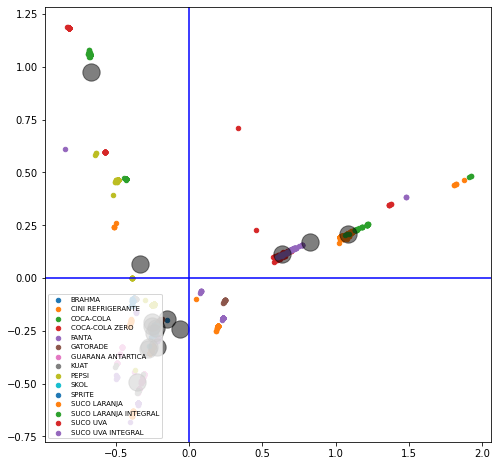

In [14]:
model = PCA(n_components=2)
transformed = model.fit_transform(X_train.todense(), y_train)
fig, ax = plt.subplots(figsize=(8,8))

for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(transformed[:,0][ix], transformed[:,1][ix], cmap='tab20b', s=20, label = le.inverse_transform([g])[0])

centers = model.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='black', alpha=0.5)

plt.legend(loc='lower left',fontsize=7)
plt.axhline(color='b')
plt.axvline(color='b')
plt.show()

#### Termos por cluster

In [15]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = count_vectorizer.get_feature_names()
for i in range(15):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ', '.join(top_ten_words)))

Cluster 0: cin, frambo, laranj, abacax, lima, guar, zer, wim, framb, citru
Cluster 1: peps, col, twist, zer, promoca, cacul, ligth, tw, antarc, light
Cluster 2: coc, col, zer, sacuc, acuc, z, divers, sem, i, fant
Cluster 3: guar, antarc, fant, zer, antar, ant, diet, promoca, antarct, z
Cluster 4: suc, laranj, natur, prat, larg, integr, vall, one, fresh, maguary
Cluster 5: skol, malt, pur, promoca, x, suc, guar, zer, coc, gatorad
Cluster 6: sprit, fresh, lemon, zer, orig, lima, acuc, sa, sem, agu
Cluster 7: suc, integr, tint, branc, larg, so, flor, alianc, nobr, laranj
Cluster 8: suc, larg, vall, tint, int, maguary, branc, natur, aur, one
Cluster 9: cin, gengibirr, zer, gass, suc, guar, coc, col, fant, peps
Cluster 10: fant, laranj, lar, zer, lja, zr, promoca, laran, guaran, suc
Cluster 11: gatorad, isoton, maracuj, isot, lima, laranj, citr, frut, morang, tangerin
Cluster 12: brahm, chopp, extr, zer, lag, malzbi, weis, alcool, red, ext
Cluster 13: skol, beat, sens, pilsen, tonic, gin, p

#### Matriz de Confusão

(<Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e12a4d0>)

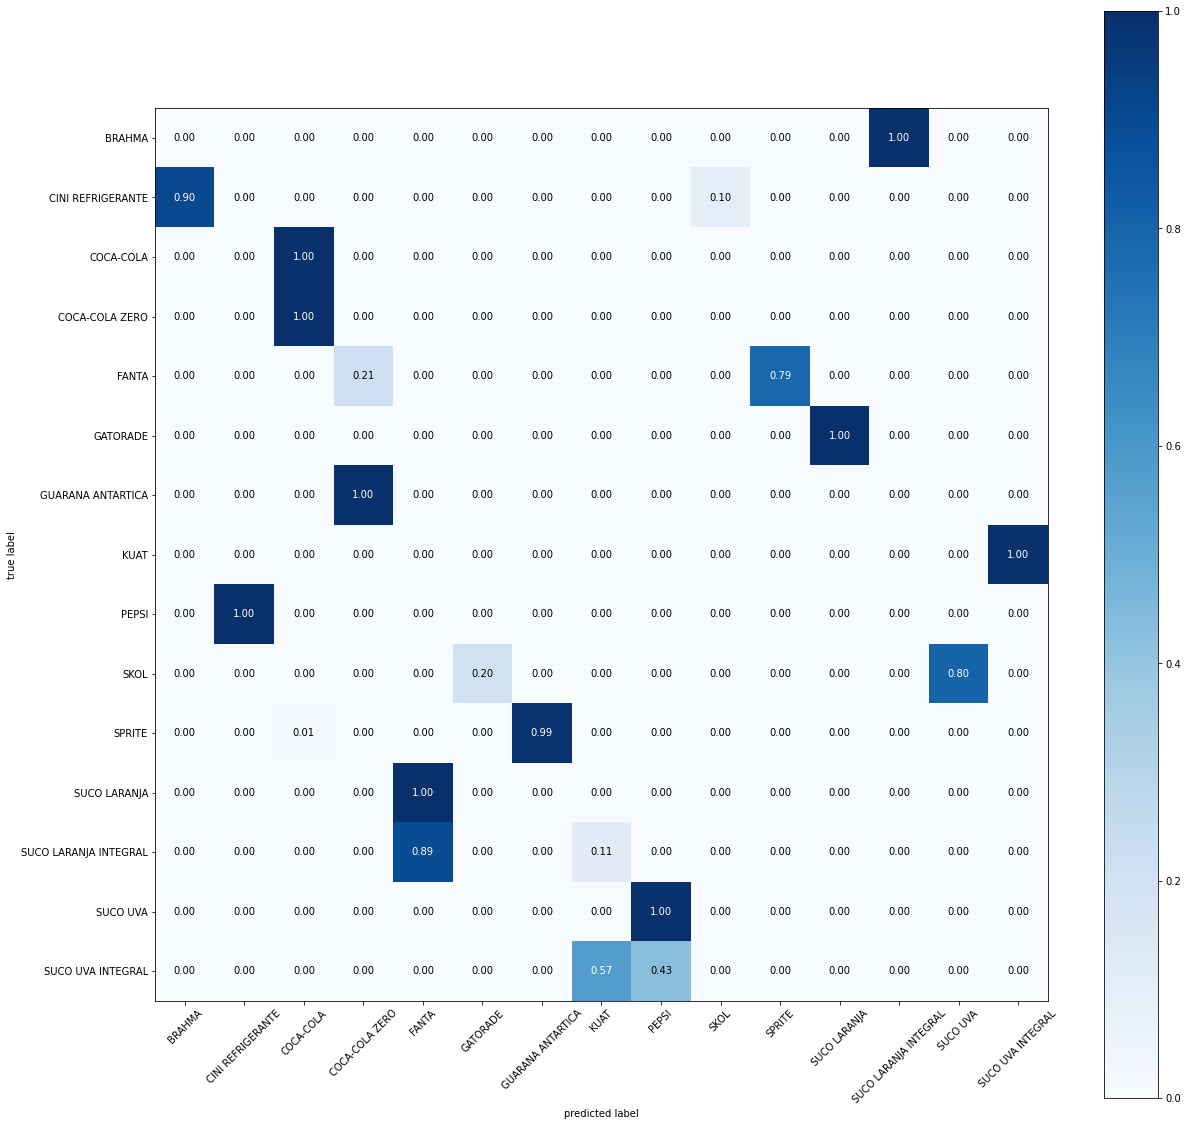

In [16]:
plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, Y_Pred),
    figsize=(20, 20),
    show_absolute=False,
    show_normed=True,
    colorbar=True,
    class_names=np.unique(le.inverse_transform(y_test))
)